# HRNet: High-Resolution Network для ключевых точек рук

HRNet — state-of-the-art архитектура для pose estimation.

**Ключевые особенности:**
1. Параллельные ветки с разным разрешением
2. Multi-scale fusion между ветками
3. Высокое разрешение сохраняется на протяжении всей сети


## Импорты


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from PIL import Image
import os
import json
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import timm

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

## Загрузка датасета FreiHAND


In [2]:
DATA_DIR = "../data/freihand"
EVAL_DIR = os.path.join(DATA_DIR, "evaluation")

if not os.path.exists(EVAL_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)
    EVAL_ZIP = os.path.join(DATA_DIR, "FreiHAND_pub_v2_eval.zip")
    print("Скачиваем FreiHAND evaluation set...")
    !wget -q --show-progress -O {EVAL_ZIP} https://lmb.informatik.uni-freiburg.de/data/freihand/FreiHAND_pub_v2_eval.zip
    print("Распаковываем архив...")
    with zipfile.ZipFile(EVAL_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    os.remove(EVAL_ZIP)
    print("Готово!")
else:
    print(f"Датасет уже существует в {EVAL_DIR}")


Датасет уже существует в ../data/freihand/evaluation


In [3]:
with open(os.path.join(DATA_DIR, "evaluation_K.json"), "r") as f:
    camera_matrices = json.load(f)

with open(os.path.join(DATA_DIR, "evaluation_xyz.json"), "r") as f:
    xyz_coordinates = json.load(f)

def project_3d_to_2d(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.dot(K, xyz.T).T
    uv = uv[:, :2] / uv[:, 2:]
    return uv

keypoints_2d = []
for i in range(len(xyz_coordinates)):
    kp_2d = project_3d_to_2d(xyz_coordinates[i], camera_matrices[i])
    keypoints_2d.append(kp_2d)

keypoints_2d = np.array(keypoints_2d)
print(f"Количество изображений: {len(keypoints_2d)}")
print(f"Количество точек на руке: {keypoints_2d.shape[1]}")


Количество изображений: 3960
Количество точек на руке: 21


## Генерация Gaussian Heatmaps


In [4]:
def generate_gaussian_heatmap(center_x, center_y, heatmap_size, sigma=2):
    x = np.arange(0, heatmap_size, 1, dtype=np.float32)
    y = np.arange(0, heatmap_size, 1, dtype=np.float32)
    y, x = np.meshgrid(y, x, indexing='ij')
    gaussian = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))
    return gaussian

def generate_heatmaps(keypoints, img_size, heatmap_size, sigma=2):
    num_keypoints = len(keypoints)
    heatmaps = np.zeros((num_keypoints, heatmap_size, heatmap_size), dtype=np.float32)
    scale = heatmap_size / img_size
    
    for i, (x, y) in enumerate(keypoints):
        hm_x = x * scale
        hm_y = y * scale
        if 0 <= hm_x < heatmap_size and 0 <= hm_y < heatmap_size:
            heatmaps[i] = generate_gaussian_heatmap(hm_x, hm_y, heatmap_size, sigma)
    
    return heatmaps


## Dataset класс


In [5]:
class FreiHandHeatmapDataset(Dataset):
    def __init__(self, data_dir, keypoints_2d, indices=None, img_size=224, heatmap_size=56, sigma=2):
        self.data_dir = data_dir
        self.img_size = img_size
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        self.indices = indices if indices is not None else list(range(len(keypoints_2d)))
        self.keypoints_2d = keypoints_2d
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        
        img_path = os.path.join(self.data_dir, "evaluation", "rgb", f"{real_idx:08d}.jpg")
        image = Image.open(img_path).convert('RGB')
        orig_w, orig_h = image.size
        
        image = self.transform(image)
        
        kp = self.keypoints_2d[real_idx].copy()
        kp[:, 0] = kp[:, 0] / orig_w * self.img_size
        kp[:, 1] = kp[:, 1] / orig_h * self.img_size
        
        heatmaps = generate_heatmaps(kp, self.img_size, self.heatmap_size, self.sigma)
        heatmaps = torch.tensor(heatmaps, dtype=torch.float32)
        
        kp_normalized = kp / self.img_size
        kp_normalized = np.clip(kp_normalized, 0, 1)
        keypoints = torch.tensor(kp_normalized, dtype=torch.float32)
        
        return image, heatmaps, keypoints


In [6]:
IMG_SIZE = 224
HEATMAP_SIZE = 56
SIGMA = 2
BATCH_SIZE = 32

NUM_SAMPLES = len(keypoints_2d)
indices = np.random.permutation(NUM_SAMPLES)

train_size = int(0.7 * NUM_SAMPLES)
val_size = int(0.15 * NUM_SAMPLES)

train_indices = indices[:train_size].tolist()
val_indices = indices[train_size:train_size + val_size].tolist()
test_indices = indices[train_size + val_size:].tolist()

train_dataset = FreiHandHeatmapDataset(DATA_DIR, keypoints_2d, train_indices, IMG_SIZE, HEATMAP_SIZE, SIGMA)
val_dataset = FreiHandHeatmapDataset(DATA_DIR, keypoints_2d, val_indices, IMG_SIZE, HEATMAP_SIZE, SIGMA)
test_dataset = FreiHandHeatmapDataset(DATA_DIR, keypoints_2d, test_indices, IMG_SIZE, HEATMAP_SIZE, SIGMA)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")


Train: 2772 samples
Val: 594 samples
Test: 594 samples


## HRNet архитектура (с предобученными весами из timm)

Используем предобученную модель HRNet из библиотеки `timm`. Это позволяет использовать веса, обученные на ImageNet, что значительно улучшает качество на маленьких датасетах.

**Преимущества:**
- Pretrained backbone уже умеет извлекать полезные признаки
- Нужно только дообучить final layer для нашей задачи
- Быстрая сходимость и лучшее качество


In [7]:
# Посмотрим доступные модели HRNet в timm
hrnet_models = [m for m in timm.list_models('*hrnet*', pretrained=True)]
print("Доступные предобученные модели HRNet:")
for m in hrnet_models:
    print(f"  - {m}")


Доступные предобученные модели HRNet:
  - hrnet_w18.ms_aug_in1k
  - hrnet_w18.ms_in1k
  - hrnet_w18_small.gluon_in1k
  - hrnet_w18_small.ms_in1k
  - hrnet_w18_small_v2.gluon_in1k
  - hrnet_w18_small_v2.ms_in1k
  - hrnet_w18_ssld.paddle_in1k
  - hrnet_w30.ms_in1k
  - hrnet_w32.ms_in1k
  - hrnet_w40.ms_in1k
  - hrnet_w44.ms_in1k
  - hrnet_w48.ms_in1k
  - hrnet_w48_ssld.paddle_in1k
  - hrnet_w64.ms_in1k


In [8]:
class HRNet(nn.Module):
    """
    HRNet с предобученными весами из timm.
    
    Используем hrnet_w32 как backbone и добавляем final layer для heatmaps.
    """
    def __init__(self, num_keypoints=21, pretrained=True, heatmap_size=56):
        super().__init__()
        self.heatmap_size = heatmap_size
        
        # Загружаем предобученный HRNet-W32 как feature extractor
        # features_only=True - возвращает промежуточные features вместо классификации
        # out_indices=(0,) - берём первую ветку (высокое разрешение)
        self.backbone = timm.create_model(
            'hrnet_w32',
            pretrained=pretrained,
            features_only=True,
            out_indices=(0,)
        )
        
        # Посмотрим информацию о выходах
        feature_info = self.backbone.feature_info
        print("Feature info:")
        for i, info in enumerate(feature_info):
            print(f"  [{i}] channels={info['num_chs']}, reduction={info['reduction']}x")
        
        # Для out_indices=(0,) получаем features с reduction=2 (112x112 для входа 224x224)
        num_features = feature_info[0]['num_chs']
        reduction = feature_info[0]['reduction']
        print(f"\nUsing output [0]: {num_features} channels, {reduction}x reduction")
        
        # Добавляем conv слой с stride=2 для downsampling 112->56
        self.downsample = nn.Sequential(
            nn.Conv2d(num_features, num_features, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features),
            nn.ReLU(inplace=True)
        )
        
        # Финальный слой для предсказания heatmaps
        self.final_layer = nn.Conv2d(num_features, num_keypoints, kernel_size=1)
        
        # Инициализация новых слоёв
        for m in [self.downsample, self.final_layer]:
            if isinstance(m, nn.Sequential):
                for layer in m:
                    if isinstance(layer, nn.Conv2d):
                        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                    elif isinstance(layer, nn.BatchNorm2d):
                        nn.init.constant_(layer.weight, 1)
                        nn.init.constant_(layer.bias, 0)
            elif isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Получаем features из backbone (112x112)
        features = self.backbone(x)
        x = features[0]
        
        # Downsample до 56x56
        x = self.downsample(x)
        
        # Применяем final layer для получения heatmaps
        out = self.final_layer(x)
        return out


In [9]:
# Проверяем размеры выхода
model_test = HRNet(num_keypoints=21, pretrained=True)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
output = model_test(dummy_input)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected heatmap size: {HEATMAP_SIZE}")
print(f"Model parameters: {sum(p.numel() for p in model_test.parameters()) / 1e6:.2f}M")
del model_test, dummy_input, output


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Feature info:
  [0] channels=64, reduction=2x
  [1] channels=128, reduction=4x
  [2] channels=256, reduction=8x
  [3] channels=512, reduction=16x
  [4] channels=1024, reduction=32x

Using output [0]: 64 channels, 2x reduction

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 21, 56, 56])
Expected heatmap size: 56
Model parameters: 30.92M


## Функция для извлечения координат из heatmaps


In [11]:
def get_max_preds(heatmaps):
    batch_size, num_joints, h, w = heatmaps.shape
    heatmaps_flat = heatmaps.view(batch_size, num_joints, -1)
    max_vals, max_indices = torch.max(heatmaps_flat, dim=2)
    
    preds = torch.zeros(batch_size, num_joints, 2, device=heatmaps.device)
    preds[:, :, 0] = max_indices % w
    preds[:, :, 1] = max_indices // w
    
    return preds, max_vals


In [12]:
class HRNetModule(pl.LightningModule):
    def __init__(self, num_keypoints=21, pretrained=True, learning_rate=1e-3, img_size=224, heatmap_size=56):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = HRNet(num_keypoints=num_keypoints, pretrained=pretrained)
        self.num_keypoints = num_keypoints
        self.learning_rate = learning_rate
        self.img_size = img_size
        self.heatmap_size = heatmap_size
        self.scale = img_size / heatmap_size
    
    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, pred_heatmaps, gt_keypoints):
        pred_coords, _ = get_max_preds(pred_heatmaps)
        pred_coords = pred_coords * self.scale
        gt_coords = gt_keypoints * self.img_size
        
        distances = torch.sqrt(((pred_coords - gt_coords) ** 2).sum(dim=-1))
        mpjpe = distances.mean()
        
        threshold = 0.05 * self.img_size
        pck = (distances < threshold).float().mean() * 100
        
        return mpjpe, pck
    
    def training_step(self, batch, batch_idx):
        images, heatmaps, keypoints = batch
        pred_heatmaps = self.forward(images)
        
        loss = F.mse_loss(pred_heatmaps, heatmaps)
        mpjpe, pck = self.compute_metrics(pred_heatmaps, keypoints)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mpjpe', mpjpe, on_step=False, on_epoch=True)
        self.log('train_pck', pck, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, heatmaps, keypoints = batch
        pred_heatmaps = self.forward(images)
        
        loss = F.mse_loss(pred_heatmaps, heatmaps)
        mpjpe, pck = self.compute_metrics(pred_heatmaps, keypoints)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mpjpe', mpjpe, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_pck', pck, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        images, heatmaps, keypoints = batch
        pred_heatmaps = self.forward(images)
        
        loss = F.mse_loss(pred_heatmaps, heatmaps)
        mpjpe, pck = self.compute_metrics(pred_heatmaps, keypoints)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_mpjpe', mpjpe, on_step=False, on_epoch=True)
        self.log('test_pck', pck, on_step=False, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
        return [optimizer], [scheduler]


## Обучение модели


In [13]:
model = HRNetModule(
    num_keypoints=21,
    pretrained=True,
    learning_rate=1e-3,  # Увеличили LR для дообучения
    img_size=IMG_SIZE,
    heatmap_size=HEATMAP_SIZE
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_mpjpe',
    mode='min',
    save_top_k=1,
    filename='hrnet-{epoch:02d}-{val_mpjpe:.2f}'
)

early_stopping = EarlyStopping(
    monitor='val_mpjpe',
    mode='min',
    patience=5
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    enable_progress_bar=True
)


Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
GPU available: T

Feature info:
  [0] channels=64, reduction=2x
  [1] channels=128, reduction=4x
  [2] channels=256, reduction=8x
  [3] channels=512, reduction=16x
  [4] channels=1024, reduction=32x

Using output [0]: 64 channels, 2x reduction


In [14]:
trainer.fit(model, train_loader, val_loader)


You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | HRNet | 30.9 M | train
----------------------------------------
30.9 M    Trainable params
0         Non-trainable params
30.9 M    Total params
123.681   Total estimated model params size (MB)
1521      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [15]:
test_results = trainer.test(model, test_loader)
print(f"\nРезультаты HRNet на тесте:")
print(f"  MPJPE: {test_results[0]['test_mpjpe']:.2f} px")
print(f"  PCK@5%: {test_results[0]['test_pck']:.1f}%")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0036100803408771753   │
│        test_mpjpe         │     36.97565460205078     │
│         test_pck          │     15.06333065032959     │
└───────────────────────────┴───────────────────────────┘


Результаты HRNet на тесте:
  MPJPE: 36.98 px
  PCK@5%: 15.1%


## Визуализация предсказаний


In [16]:
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()

SKELETON = [
    [0, 1], [1, 2], [2, 3], [3, 4],
    [0, 5], [5, 6], [6, 7], [7, 8],
    [0, 9], [9, 10], [10, 11], [11, 12],
    [0, 13], [13, 14], [14, 15], [15, 16],
    [0, 17], [17, 18], [18, 19], [19, 20]
]


In [17]:
def visualize_predictions(model, dataset, num_samples=8):
    model.eval()
    device = next(model.parameters()).device
    scale = IMG_SIZE / HEATMAP_SIZE
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, _, gt_kp = dataset[idx]
            
            pred_heatmaps = model(image.unsqueeze(0).to(device)).cpu().squeeze()
            pred_coords, _ = get_max_preds(pred_heatmaps.unsqueeze(0))
            pred_coords = pred_coords.squeeze().numpy() * scale
            
            gt_coords = gt_kp.numpy() * IMG_SIZE
            
            img_np = denormalize_image(image)
            
            axes[i].imshow(img_np)
            
            for edge in SKELETON:
                axes[i].plot([gt_coords[edge[0], 0], gt_coords[edge[1], 0]],
                            [gt_coords[edge[0], 1], gt_coords[edge[1], 1]],
                            color='lime', linewidth=2, alpha=0.7)
                axes[i].plot([pred_coords[edge[0], 0], pred_coords[edge[1], 0]],
                            [pred_coords[edge[0], 1], pred_coords[edge[1], 1]],
                            color='red', linewidth=2, alpha=0.7)
            
            axes[i].scatter(gt_coords[:, 0], gt_coords[:, 1], c='lime', s=25, zorder=5, edgecolors='black')
            axes[i].scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', s=25, zorder=5, edgecolors='black')
            
            error = np.sqrt(((gt_coords - pred_coords) ** 2).sum(axis=1)).mean()
            axes[i].set_title(f'MPJPE: {error:.1f} px')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


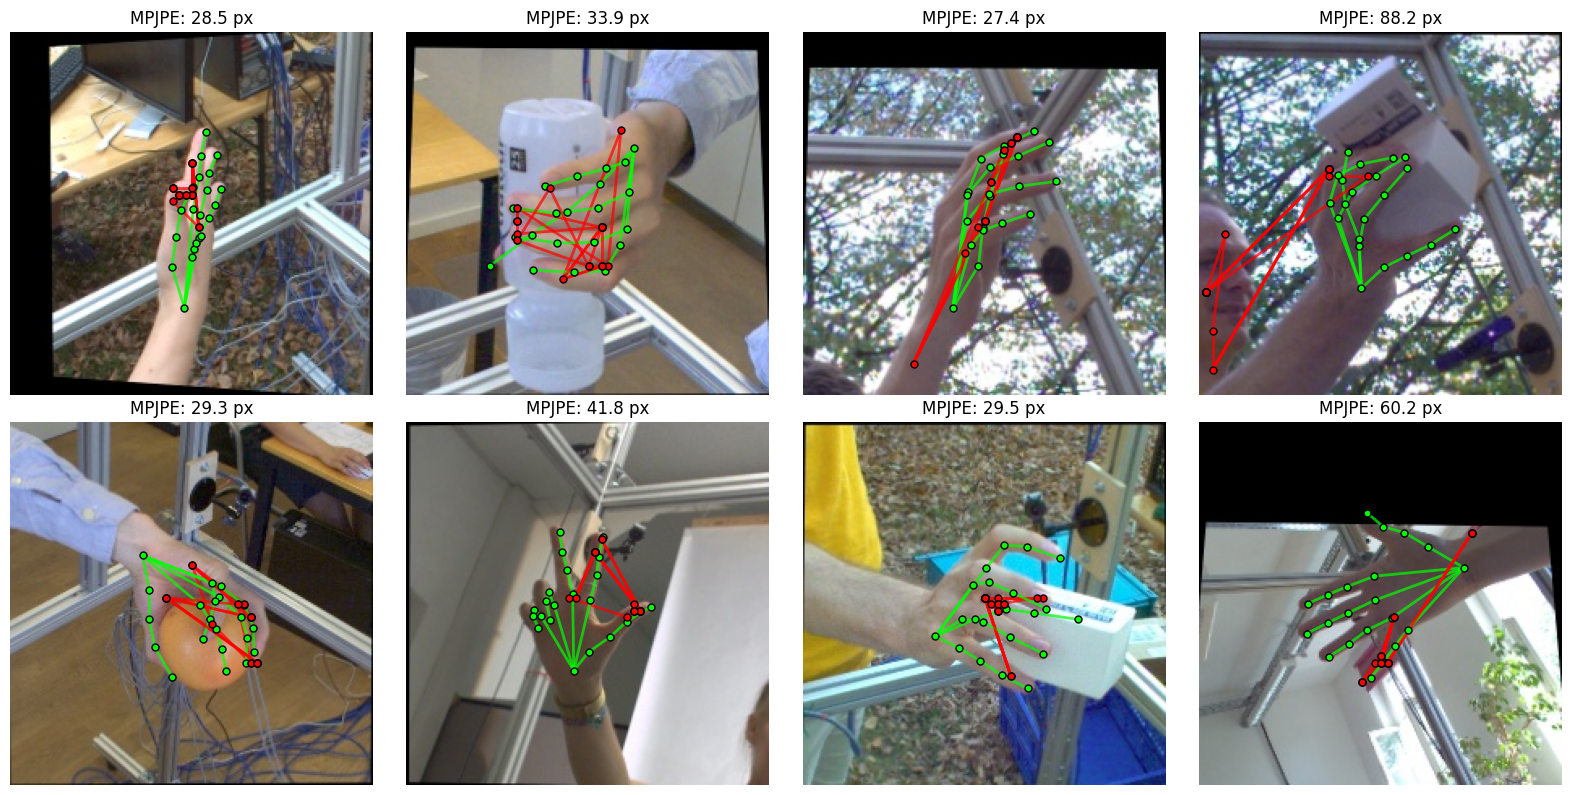

In [18]:
visualize_predictions(model, test_dataset, num_samples=8)


## Анализ ошибок по точкам


In [19]:
KEYPOINT_NAMES = [
    'Wrist',
    'Thumb_CMC', 'Thumb_MCP', 'Thumb_IP', 'Thumb_Tip',
    'Index_MCP', 'Index_PIP', 'Index_DIP', 'Index_Tip',
    'Middle_MCP', 'Middle_PIP', 'Middle_DIP', 'Middle_Tip',
    'Ring_MCP', 'Ring_PIP', 'Ring_DIP', 'Ring_Tip',
    'Pinky_MCP', 'Pinky_PIP', 'Pinky_DIP', 'Pinky_Tip'
]

def compute_per_keypoint_error(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    scale = IMG_SIZE / HEATMAP_SIZE
    
    all_errors = []
    
    with torch.no_grad():
        for images, _, keypoints in tqdm(dataloader, desc="Computing errors"):
            images = images.to(device)
            pred_heatmaps = model(images).cpu()
            
            pred_coords, _ = get_max_preds(pred_heatmaps)
            pred_coords = pred_coords * scale
            gt_coords = keypoints * IMG_SIZE
            
            errors = torch.sqrt(((pred_coords - gt_coords) ** 2).sum(dim=-1))
            all_errors.append(errors)
    
    all_errors = torch.cat(all_errors, dim=0)
    return all_errors.mean(dim=0).numpy()


Computing errors: 100%|██████████| 19/19 [01:28<00:00,  4.64s/it]


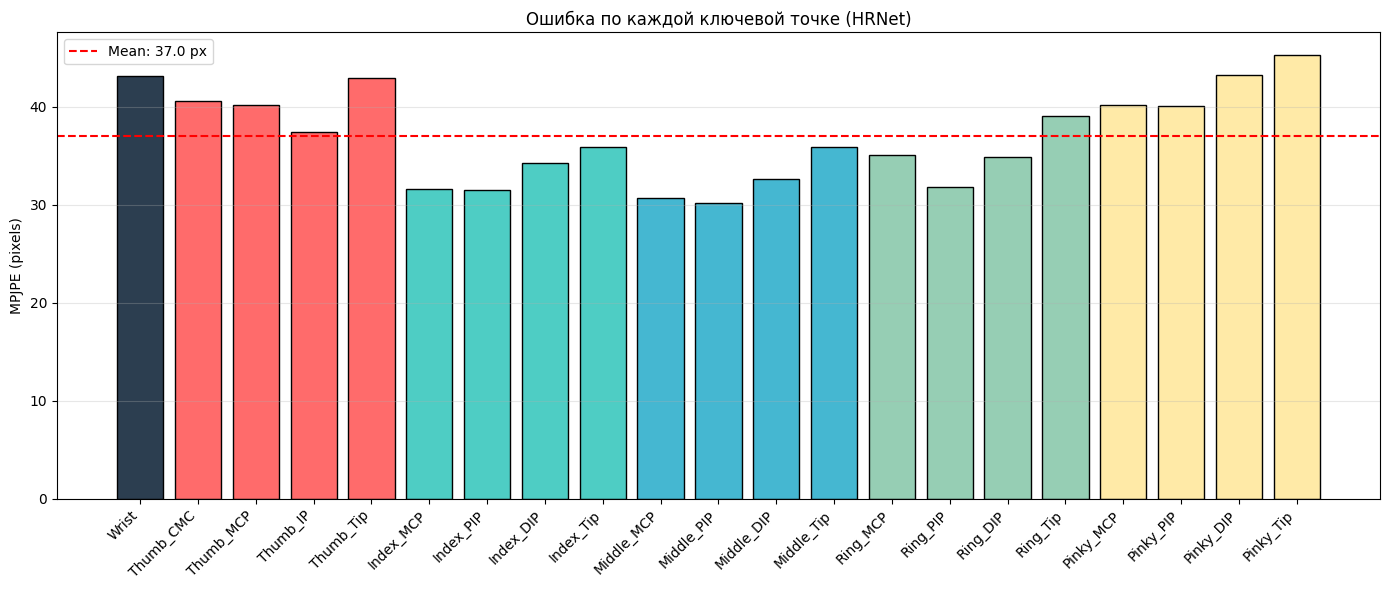

In [20]:
per_kp_errors = compute_per_keypoint_error(model, test_loader)

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#2C3E50'] + ['#FF6B6B']*4 + ['#4ECDC4']*4 + ['#45B7D1']*4 + ['#96CEB4']*4 + ['#FFEAA7']*4

bars = ax.bar(range(21), per_kp_errors, color=colors, edgecolor='black')
ax.set_xticks(range(21))
ax.set_xticklabels(KEYPOINT_NAMES, rotation=45, ha='right')
ax.set_ylabel('MPJPE (pixels)')
ax.set_title('Ошибка по каждой ключевой точке (HRNet)')
ax.axhline(y=per_kp_errors.mean(), color='red', linestyle='--', label=f'Mean: {per_kp_errors.mean():.1f} px')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## PCK при разных порогах


In [21]:
def compute_pck_curve(model, dataloader, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.2, 20)
    
    model.eval()
    device = next(model.parameters()).device
    scale = IMG_SIZE / HEATMAP_SIZE
    
    all_distances = []
    
    with torch.no_grad():
        for images, _, keypoints in dataloader:
            images = images.to(device)
            pred_heatmaps = model(images).cpu()
            
            pred_coords, _ = get_max_preds(pred_heatmaps)
            pred_coords = pred_coords * scale
            gt_coords = keypoints * IMG_SIZE
            
            distances = torch.sqrt(((pred_coords - gt_coords) ** 2).sum(dim=-1))
            all_distances.append(distances)
    
    all_distances = torch.cat(all_distances, dim=0)
    
    pck_values = []
    for thresh in thresholds:
        threshold_px = thresh * IMG_SIZE
        pck = (all_distances < threshold_px).float().mean().item() * 100
        pck_values.append(pck)
    
    return thresholds, pck_values


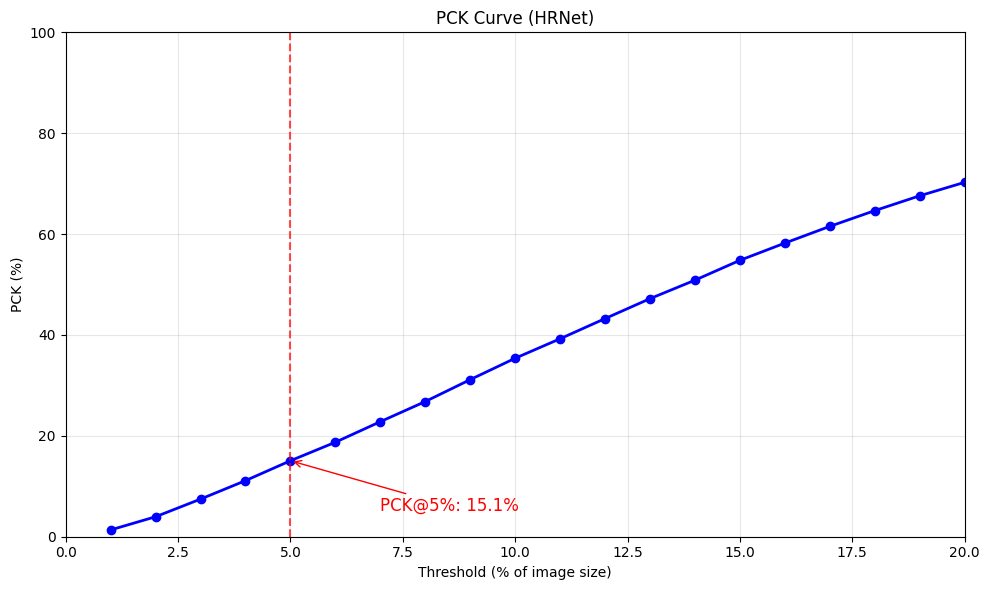

In [22]:
thresholds, pck_values = compute_pck_curve(model, test_loader)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds * 100, pck_values, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Threshold (% of image size)')
ax.set_ylabel('PCK (%)')
ax.set_title('PCK Curve (HRNet)')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 20])
ax.set_ylim([0, 100])

ax.axvline(x=5, color='red', linestyle='--', alpha=0.7)
pck_5 = pck_values[np.argmin(np.abs(thresholds - 0.05))]
ax.annotate(f'PCK@5%: {pck_5:.1f}%', xy=(5, pck_5), xytext=(7, pck_5-10),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, color='red')

plt.tight_layout()
plt.show()
